In [1]:
%load_ext autoreload
%autoreload 2

## Shapley value defintion
Given a set of n elements, $U := \{1, \cdots, n\}$ and a function

$g: 2^U \rightarrow \mathbb{R}$ with $g(U) \neq 0$, $g(\varnothing)=0$

define $C(j|T) := g(T \cup \{j\}) - g(T)$ with $T \subseteq U$.

Feture i's contribution:

$\phi_i := \sum_{T \subseteq U} \frac{|T|! (n-1-|T|)!}{n!} C(i|T)$

where
$g(T) := f_T(x_T) - f(x')$ with $f_\varnothing(x_\varnothing) = f(x')$ for some baseline $x'$. 

$f_T(x_T) := \mathbb{E}[ f(x_T, X_{\bar{T}}) | z]$  where $z$ is a hyperparameter

previous approaches considers
- unconditional: $z := \varnothing$
- conditional: $z := \{X_T = x_T \}$

we in addition consider using a causal graph
- do: $z := \{do(X_T = x_T)\}$

## Assumptions
- no unobserved confounders

## Hyper parameters
- dropped_feature_imputation: unconditional, conditional, do 
- timelines: all, last (permutation importance), valid

In [30]:
import networkx as nx
from graphviz import Digraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, check_baseline_target, Graph

# Sanity check with linear models

In [57]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = x1 + x2
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    y  = Node('target', lambda x1, x2: x1 + x2, [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1.5, 'target': 2.5})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=True, nruns=1)
graph = build_graph()
cf.run(graph)

sample baseline {'x1': 0, 'x2': 0, 'target': 0}
target values {'x1': 1, 'x2': 1.5, 'target': 2.5}
outcome additive noise for x2 is 0.5
using order [x1, x2, target]
baselines x1: 0, x2: 0, target: 0
turn on node x1 form 0 to 1
turn on edge x1->target
target changes from 0 to 1
assign 1 credits to x1->target
assign 1 credits to x1_noise->x1
turn on edge x1->x2
x2 changes from 0 to 1
turn on edge x2->target
target changes from 1 to 2
assign 1 credits to x2->target
assign 1 credits to x1->x2
assign 1 credits to x1_noise->x1
turn on node x2 form 1 to 1.5
turn on edge x2->target
target changes from 2 to 2.5
assign 0.5 credits to x2->target
assign 0.5 credits to x2_noise->x2
turn on node target form 2.5 to 2.5
assign 0.0 credits to target_noise->target


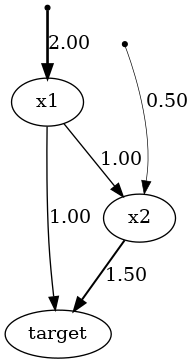

In [16]:
dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

In this example, [x1, x2, target] is the only valid timeline. However, there are 2 paths to the output. They give the same explanation for linear models.

# Nonlinear synthetic data

# 0 baseline model

```python
x1 = Node('health status')
x2 = Node('scanner type', lambda x1: 0.9 if x1 <= 0.1 else 0.3, [x1])
y  = Node('mortality', lambda x1, x2: x2, 
          [x1, x2], is_target_node=True)
```

sample baseline {'health status': 1, 'scanner type': 0, 'mortality': 0}
target values {'health status': 0.1, 'scanner type': 1, 'mortality': 1}
baseline additive noise for scanner type is -0.3
outcome additive noise for scanner type is 0.09999999999999998
using order [health status, scanner type, mortality]
baselines health status: 1, scanner type: 0, mortality: 0
turn on node health status form 1 to 0.1
turn on edge health status->scanner type
scanner type changes from 0 to 0.9
turn on edge scanner type->mortality
mortality changes from 0 to 0.9
assign 0.9 credits to scanner type->mortality
assign 0.9 credits to health status->scanner type
assign 0.9 credits to health status_noise->health status
turn on edge health status->mortality
mortality changes from 0.9 to 0.9
assign 0.0 credits to health status->mortality
assign 0.0 credits to health status_noise->health status
turn on node scanner type form 0.9 to 1
turn on edge scanner type->mortality
mortality changes from 0.9 to 1
assign 0.

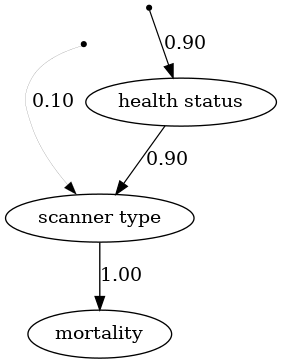

In [58]:
def health_data():
    '''synthetic health data'''
    health_status = 1
    scanner_type = 0 
    #mortality = 1 if health_status <= 0.1 else 0
    return {
        'health status': health_status,
        'scanner type': scanner_type,
    #    'mortality': mortality
    }

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 0.9 if x1 <= 0.1 else 0.3, [x1])
    y  = Node('mortality', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y], health_data, 
                 {
                     'health status': 0.1,
                     'scanner type': 1,
                     'mortality': 1
                 })
   
    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)
   
    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=True, nruns=1)
graph = build_health_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

$\text{health status} \sim U([0, 1])$

$P(\text{scanner type = "portable"}) = 
\begin{cases}
    0.9, & \text{if } \text{health status} \leq 0.1 \\
    0.3,               & \text{otherwise}
\end{cases}$

$\text{mortality} =
\begin{cases}
    1, & \text{if } \text{health status} \leq 0.1 \\
    0,               & \text{otherwise}
\end{cases}$


{'health status': 0.37031658486351815, 'scanner type': 1, 'mortality': 0}
baseline additive noise for scanner type is -0.3
outcome additive noise for scanner type is 0.09999999999999998


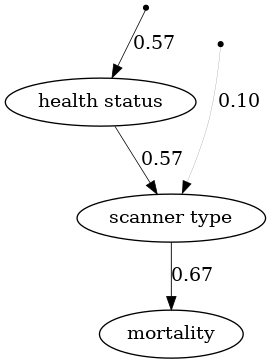

In [17]:
def health_data():
    '''synthetic health data'''
    health_status = np.random.uniform(0, 1)
    scanner_type = np.random.choice([0, 1], 
                                    p=[0.1 if health_status <= 0.1 else 0.7,
                                       0.9 if health_status <= 0.1 else 0.3]) 
    mortality = 1 if health_status <= 0.1 else 0
    return {
        'health status': health_status,
        'scanner type': scanner_type,
        'mortality': mortality
    }

print(health_data())

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2, x3)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 0.9 if x1 <= 0.1 else 0.3, [x1])
    y  = Node('mortality', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y], health_data, 
                 {
                     'health status': 0.1,
                     'scanner type': 1,
                     'mortality': 1
                 })
   
    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1000)
graph = build_health_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

# Can handle AND
```python
 y  = Node('mortality', lambda x1, x2: (x1 <= 0.1) and x2, 
              [x1, x2], is_target_node=True)
```

{'health status': 0.380832961551577, 'scanner type': 0, 'mortality': 0}


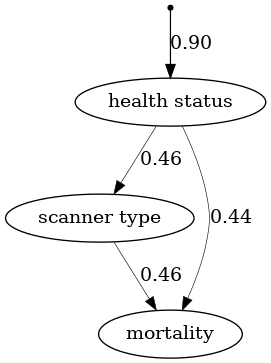

In [19]:
def health_data():
    '''synthetic health data'''
    health_status = np.random.uniform(0, 1)
    scanner_type = np.random.choice([0, 1], 
                                    p=[0 if health_status <= 0.1 else 1,
                                       1 if health_status <= 0.1 else 0]) 
    mortality = 1 if health_status <= 0.1 else 0
    return {
        'health status': health_status,
        'scanner type': scanner_type,
        'mortality': mortality
    }

print(health_data())

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2->x3, y = f(x1, x2, x3)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 1 if x1 <= 0.1 else 0, [x1])
    # x2 = Node('scanner type')
    y  = Node('mortality', lambda x1, x2: (x1 <= 0.1) and x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y], health_data, 
                 {
                     'health status': 0.1,
                     'scanner type': 1,
                     'mortality': 1
                 })
   
    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=3000)
graph = build_health_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

# Cannot handle the following graph

This fails edge first flow (flow1.py) because the red edge can only appear first or last.

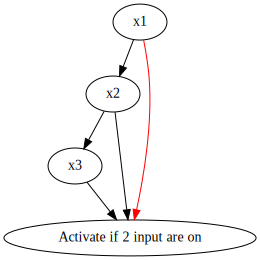

In [54]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['12', '23', '2y', '3y'])
dot.edge('1', 'y', color='red')
dot

sample baseline {'x1': 0, 'x2': 0, 'x3': 0, 'target': 0}
target values {'x1': 1, 'x2': 1, 'x3': 1, 'target': 1}


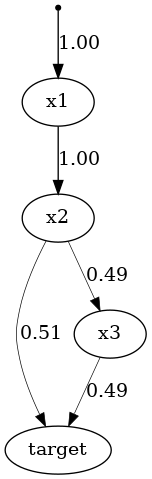

In [60]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    x3 = Node('x3', lambda x1: x1, [x2])
    y  = Node('target', lambda x1, x2, x3: int(x1 + x2 + x3 >= 2), 
              [x1, x2, x3], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x3, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'x3': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1,  'x3': 1, 'target': 1})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=100)
graph = build_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')